<a href="https://colab.research.google.com/github/mobraine/Computational-Neuroscience/blob/main/RNN_Zilong_Wang_260823366_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from utils import *
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


# Generate training data

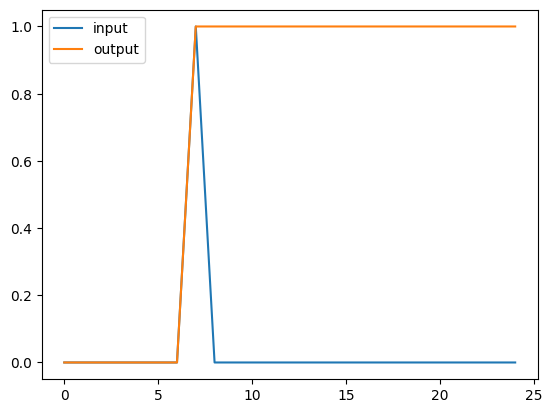

In [3]:

num_trials = 12800
num_steps = 25
num_channels = 3
generator = StimGen()
xs = []
ys = []
for i in range(num_trials):
    # YOUR CODE GOES HERE
    # Generate training data (Step1: Deliverable3)
    x, y = generator.generate(num_steps, num_channels)
    xs.append(x)
    ys.append(y)

xs=np.array(xs)
ys=np.array(ys)
plt.plot(xs[0, 0,:])
plt.plot(ys[0, 0,:])
plt.legend(['input', 'output'])
plt.show()


In [4]:
batch_size = 128
xs = torch.tensor(np.float32(xs))
ys = torch.tensor(np.float32(ys))

dataset = TensorDataset(xs, ys)
loader_train = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training the RNN

/content/utils.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.iweight)
/content/utils.py:46: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  torch.nn.init.orthogonal(self.hweight)
/content/utils.py:47: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.oweight)


0 5.5184216
1 3.7402484
2 1.7346939
3 0.52267975
4 0.81654745
5 0.47423658
6 0.41804123
7 0.26874438
8 0.33832675
9 0.11034059
10 0.07599724
11 0.25012413
12 0.20229381
13 0.16374785
14 0.16013333
15 0.05390717
16 0.10013201
17 0.2522753
18 0.080820195
19 0.07723363
20 0.14160642
21 0.13092494
22 0.12331703
23 0.11144413
24 0.1030898
25 0.12177187
26 0.207383
27 0.07823698
28 0.06884266
29 0.19054365
30 0.1863167
31 0.098920465
32 0.031727277
33 0.06156278
34 0.09437817
35 0.23328291
36 0.09690301
37 0.07014117
38 0.061273392
39 0.1869956
40 0.11489158
41 0.26751417
42 0.09458382
43 0.14489222
44 0.14021637
45 0.15517175
46 0.07409633
47 0.094937325
48 0.04459183
49 0.029192569


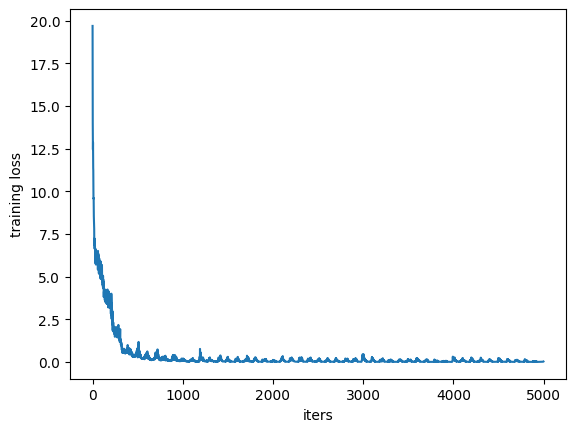

In [5]:
num_epochs = 50
lr_init = 1e-3
num_hidden = 512

rnn = simpleRNN(num_channels, num_hidden)
optimizer = optim.Adam(rnn.parameters(), lr=lr_init, weight_decay=0)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, last_epoch=-1)

losses = []
for epoch in range(num_epochs):
    rnn.train()
    for i, (x, y) in enumerate(loader_train):
        mse_loss = 0
        h_now = torch.zeros(x.shape[0], num_hidden)
        for t in range(x.shape[-1]):
            o_now, h_now = rnn(x[:, :, t].to(device), h_now.to(device))
            mse_loss += loss_fn(o_now, y[:, :, t])
        losses.append(mse_loss.detach().numpy())
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()
        scheduler.step()
        # print(epoch, i, mse_loss)
    print(epoch, losses[-1])

# YOUR CODE GOES HERE
# Plot training loss (Step2: Deliverable 2)
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('training loss')
plt.show()

# Get unit activity for validation data

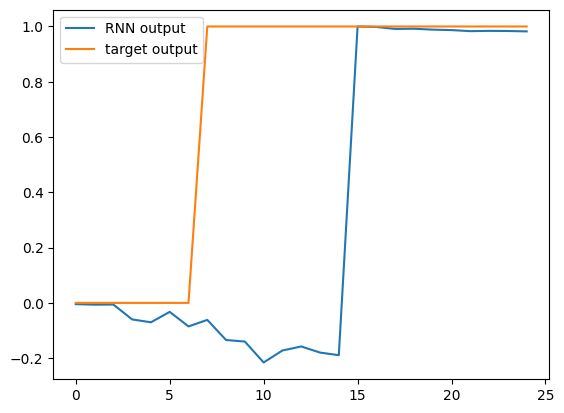

In [11]:
# YOUR CODE GOES HERE
# Generate validation dataset (Step2: Deliverable 3)

num_trials = 1280

generator = StimGen()
xs_val = []
ys_val = []

for i in range(num_trials):
    x, y = generator.generate(num_steps, num_channels)
    xs_val.append(x)
    ys_val.append(y)

xs_val = torch.tensor(np.float32(xs_val))
ys_val = torch.tensor(np.float32(ys_val))
dataset_val = TensorDataset(xs_val, ys_val)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

rnn.eval()
os, hs = get_activation(rnn, loader_val, device)


# Plot the target output and the RNN output (Step2: Deliverable 3)
plt.plot(os[0, 0,:].detach().numpy())
plt.plot(ys[0, 0,:])
plt.legend(['RNN output', 'target output'])
plt.show()

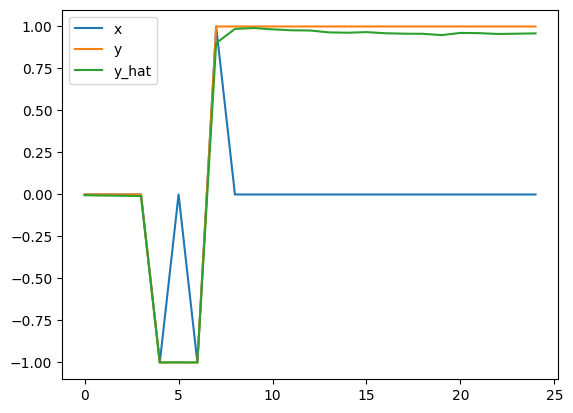

In [7]:
idx = 12
plt.plot(xs_val.numpy()[idx, 0])
plt.plot(ys_val.numpy()[idx, 0])
plt.plot(os.detach().numpy()[idx, 0, :])
plt.legend(['x', 'y', 'y_hat'])
plt.show()

# Computing PCA on validation data

In [41]:
# Apply PCA on RNN hidden states (states variable) and plot 3 random
# trajectories (Step3: Deliverable1)
# YOUR CODE GOES HERE

hs_reordered = hs.permute(0, 2, 1)  # New shape will be [1280, 25, 512]
combined_size = hs_reordered.shape[0] * hs_reordered.shape[1]
hs_reshaped = hs_reordered.reshape(combined_size, -1) # New shape will be [1280*25, 512]

h_mu = hs_reshaped.mean(0)
hs_demeaned = hs_reshaped - h_mu
pca = PCA(n_components=3)
hs_pca = pca.fit_transform(hs_demeaned.detach().numpy())



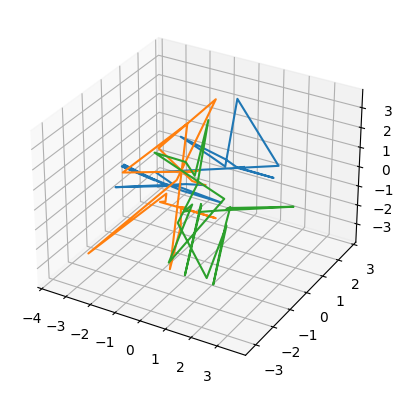

In [42]:
ax = plt.figure().add_subplot(projection='3d')
# ax.plot3D(np.matmul(hs_reordered[503,:,:].detach().numpy(), pca.components_[0].T),
#           np.matmul(hs_reordered[503,:,:].detach().numpy(), pca.components_[1].T),
#           np.matmul(hs_reordered[503,:,:].detach().numpy(), pca.components_[2].T),)

# ax.plot3D(np.matmul(hs_reordered[678,:,:].detach().numpy(), pca.components_[0].T),
#           np.matmul(hs_reordered[678,:,:].detach().numpy(), pca.components_[1].T),
#           np.matmul(hs_reordered[678,:,:].detach().numpy(), pca.components_[2].T),)

# ax.plot3D(np.matmul(hs_reordered[271,:,:].detach().numpy(), pca.components_[0].T),
#           np.matmul(hs_reordered[271,:,:].detach().numpy(), pca.components_[1].T),
#           np.matmul(hs_reordered[271,:,:].detach().numpy(), pca.components_[2].T),)

# ax.plot3D(hs_pca[271,0], hs_pca[271,1], hs_pca[271,2])


ax.plot3D(hs_pca[0:25,0], hs_pca[0:25,1], hs_pca[0:25,2])
ax.plot3D(hs_pca[125:150,0], hs_pca[125:150,1], hs_pca[125:150,2])
ax.plot3D(hs_pca[500:525,0], hs_pca[500:525,1], hs_pca[500:525,2])

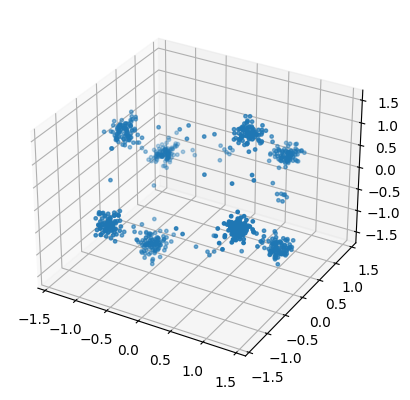

In [52]:
# Scatter plot of the end states (Step3: Deliverable2)
ax = plt.figure().add_subplot(projection='3d')

# PC1_end_state = np.matmul(hs_reordered[:, -1, :].detach().numpy(), pca.components_[0].T)
# PC2_end_state = np.matmul(hs_reordered[:, -1, :].detach().numpy(), pca.components_[1].T)
# PC3_end_state = np.matmul(hs_reordered[:, -1, :].detach().numpy(), pca.components_[2].T)

# ind to plot
inds = [i for i in range(24, combined_size, 25)]
PC1_end_state = hs_pca[inds, 0]
PC2_end_state = hs_pca[inds, 1]
PC3_end_state = hs_pca[inds, 2]

ax.scatter3D(PC1_end_state, PC2_end_state, PC3_end_state, s=6)
plt.show()



#There are 8 CLUSTERS positioned around the 8 permutations of coordinates ($\pm$1, $\pm$1, $\pm$1)

# Attractor Points

In [47]:
# YOUR CODE GOES HERE
# Run the network with zero inputs from random initial states (Step4)
random_initial_state = [torch.rand(512) for i in range(200)]
empty_input = torch.zeros((num_channels, 100))

hs_rand = []
for h_rand in random_initial_state:
  rnn.eval()
  batch_rand = []
  h_now = h_rand
  for t in range(empty_input.shape[-1]):
      _, h_now = rnn(empty_input[:, t].to(device), h_now.to(device))
      batch_rand.append(h_now)
  hs_rand.append(torch.stack(batch_rand, -1))

hs_rand = torch.concat(hs_rand, dim=0)

In [48]:
hs_rand_reordered = hs_rand.permute(0, 2, 1)
combined_size = hs_rand_reordered.shape[0] * hs_rand_reordered.shape[1]
hs_rand_reshaped = hs_rand_reordered.reshape(combined_size, -1) # New shape will be [1280*25, 512]


hs_rand_demeaned = hs_rand_reshaped - h_mu
hs_rand_pca = pca.transform(hs_rand_demeaned.detach().numpy())

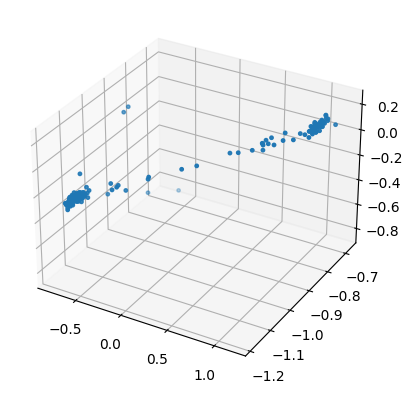

In [51]:
# ind to plot
inds = [i for i in range(99, combined_size, 100)]
PC1_end_state = hs_rand_pca[inds, 0]
PC2_end_state = hs_rand_pca[inds, 1]
PC3_end_state = hs_rand_pca[inds, 2]

ax = plt.figure().add_subplot(projection='3d')
ax.scatter3D(PC1_end_state, PC2_end_state, PC3_end_state, s=6)
plt.show()




In [62]:
# pca.singular_values_
pca.explained_variance_

array([1.9851385, 1.8167512, 1.7929268], dtype=float32)

# There are two clusters. As we can see from the pca explained variance, the top two components have relatively larger eigenvalues and thus the hidden states will be attracted to the these two directions, forming two clusters.

# (Bonus) Choice axis and the geometry of attractor points  

In [63]:
# YOUR CODE GOES HERE
#  the alignment between output weights and the attractor points (Step5)
os.shape

torch.Size([1280, 3, 25])

In [ ]:
os_reordered = os.permute(0, 2, 1)  # New shape will be [1280, 25, 512]
combined_size = os_reordered.shape[0] * os_reordered.shape[1]
os_reshaped = os_reordered.reshape(combined_size, -1)

# ind to plot
inds = [i for i in range(24, combined_size, 25)]
inds_red = np.where(os_reshaped[inds, 0].detach().numpy() == 1)
inds_blue = np.where(os_reshaped[inds, 0].detach().numpy() == -1)
# os_reshaped[inds, 0]??